In [1]:
# import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn as sk
from __future__ import division
from sklearn.cross_validation import train_test_split
import math

from tqdm import trange
from sklearn.svm import SVC

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
# read the excel sheet 
df = pd.read_excel('./BioCode for Machine Learning Updated.xlsx')

# Read in the labels
cls = df['Classification']

# Read the DNA sequences, which are strings comprised of the letters ATCG
seq = df['Aligned Sequence']

species = df['NCBI_Genus_species']

In [13]:
print 'Unique species: '+ str(len(set(df['NCBI_Genus_species'])))

print 'Unique Aligned Sequences: ' + str(len(set(df['Aligned Sequence'])))

Unique species: 764
Unique Aligned Sequences: 2984


In [14]:
# Convert DNA data to numpy array, and convert NaNs to Nones
seq = np.array(seq.fillna('None'))

# Create a binary filter to eliminate invalid DNA sequences
valid_idx = np.array([i for i in range(len(seq)) if seq[i] != 'None'])

# Apply the filter
valid_seq = seq[valid_idx]
cls_valid = cls[valid_idx]
cls_valid = np.array(cls_valid)
species_valid = species[valid_idx]
species_valid = np.array(species_valid)

In [16]:
# Seperate string into individual characters
seq_arrays = [np.array([i for i in s]) for s in valid_seq]

mat_size = len(seq_arrays)

print(len(valid_seq), len(cls_valid), mat_size, len(species_valid))

(4459, 4459, 4459, 4459)


In [17]:
sim_mat = -np.ones((mat_size, mat_size))

# Precomputer no dashes
dashes = []
for i in range(mat_size):
    dashes.append(seq_arrays[i] != '-')

# this will take a few minutes
for i in trange(mat_size):
    # clean up bad data
    a = seq_arrays[i]
    # iterate over DNA sequences and figure out the match
    for j in range(i):
        b = seq_arrays[j]
        match = (a==b)
        valid = (dashes[i] * dashes[j])
        sim_mat[i,j] = np.mean(match[valid])
        sim_mat[j,i] = sim_mat[i,j]
    sim_mat[i,i] = 1

100%|██████████| 4459/4459 [03:17<00:00, 22.56it/s] 


In [18]:
sim_mat

array([[ 1.        ,  1.        ,  0.81430746, ...,  0.71338583,
         0.69431644,  0.69779287],
       [ 1.        ,  1.        ,  0.81430746, ...,  0.71338583,
         0.69431644,  0.69779287],
       [ 0.81430746,  0.81430746,  1.        , ...,  0.72440945,
         0.67281106,  0.67232598],
       ..., 
       [ 0.71338583,  0.71338583,  0.72440945, ...,  1.        ,
         0.75548589,  0.75      ],
       [ 0.69431644,  0.69431644,  0.67281106, ...,  0.75548589,
         1.        ,  1.        ],
       [ 0.69779287,  0.69779287,  0.67232598, ...,  0.75      ,
         1.        ,  1.        ]])

In [99]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import axes3d

pca = PCA(n_components=3)
pca.fit(sim_mat)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

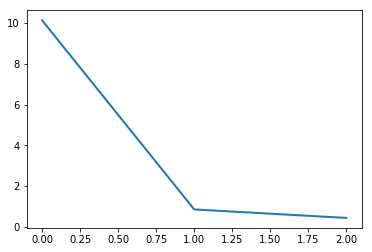

In [100]:
plt.plot(pca.explained_variance_, linewidth=2)
x_r = pca.transform(sim_mat)

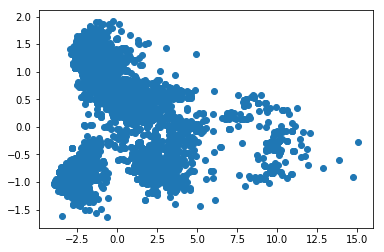

In [101]:
plt.scatter(x_r[:,0], x_r[:,1])

# 3D
if False:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
    ax = fig.gca(projection='3d')
    ax.scatter(x_r[:,0], x_r[:,1], x_r[:,2])

In [104]:
from sklearn.cluster import KMeans

clstr = KMeans(n_clusters=750)
clstr.fit(x_r[:4000])
pred = clstr.predict(x_r[4000:])

In [107]:
import pandas as pd

purities = []

for k in range(650, 750, 5):

    clstr = KMeans(n_clusters=750)
    clstr.fit(x_r[:4000])
    pred = clstr.predict(x_r[4000:])

    # Calculate purity of clusters
    clusters = set(pred)

    print species_valid[4000 + np.where(pred == 272)[0]]
    labels = species_valid[4000 + np.where(pred == 272)[0]]
    print np.unique(labels, return_counts=True)

    # Purity = \sum max # correctly classified in cluster
    tot = 0
    for cluster_num in clusters:
        labels = species_valid[4000 + np.where(pred == cluster_num)[0]]
        # Drop nans
        labels = labels[pd.isnull(labels) == False]

        # If not all are nans
        if len(labels) != 0:
            _, counts = np.unique(labels, return_counts=True)
            tot += np.max(counts)

    print tot
    # Total num objects = total objects - nans
    print len(species_valid[4000:]) - np.sum(pd.isnull(species_valid[4000:]))
    print tot / float(len(species_valid[4000:]) - np.sum(pd.isnull(species_valid[4000:])))
    
    purities.append(tot / float(len(species_valid[4000:]) - np.sum(pd.isnull(species_valid[4000:]))))

[]
(array([], dtype=object), array([], dtype=int64))
223
269
0.828996282528
[]
(array([], dtype=object), array([], dtype=int64))
235
269
0.873605947955
[]
(array([], dtype=object), array([], dtype=int64))
220
269
0.817843866171
[]
(array([], dtype=object), array([], dtype=int64))
227
269
0.843866171004
[]
(array([], dtype=object), array([], dtype=int64))
224
269
0.832713754647
[]
(array([], dtype=object), array([], dtype=int64))
220
269
0.817843866171
[]
(array([], dtype=object), array([], dtype=int64))
230
269
0.855018587361
[]
(array([], dtype=object), array([], dtype=int64))
225
269
0.836431226766
[]
(array([], dtype=object), array([], dtype=int64))
234
269
0.869888475836
[]
(array([], dtype=object), array([], dtype=int64))
227
269
0.843866171004
[]
(array([], dtype=object), array([], dtype=int64))
228
269
0.847583643123
[]
(array([], dtype=object), array([], dtype=int64))
224
269
0.832713754647
[]
(array([], dtype=object), array([], dtype=int64))
223
269
0.828996282528
[]
(array([]

In [130]:
# apply the filter over our features and labels
# supervised_X = approx[labeled_cls]
# full_supervised_X = valid_mat[labeled_cls]
supervised_y = cls_valid[labeled_cls]
supervised_y = (supervised_y == 'Indigenous').astype(int)

In [131]:
unique = set()
species_filter = []
for i in species_valid:
    if i not in unique:
        species_filter.append(True)
        unique.add(i)
    else:
        species_filter.append(False)

In [132]:
# supervised_X = supervised_X[species_filter]
# full_supervised_X = full_supervised_X[species_filter]
supervised_y = supervised_y[species_filter]
feats = feats[species_filter]

In [133]:
print(feats.shape)
test_train_ratio = 0.5
feats_train, feats_test, y_train, y_test = train_test_split(feats, supervised_y, test_size=test_train_ratio)

(231, 4)


In [134]:
print(feats_train.shape, feats_test.shape)

(115, 4) (116, 4)


In [136]:
print(np.mean(y_test))

0.189655172414


In [119]:
for i in range(len(feats)):
    print(feats[i])

[0.190333333 0.029 0.0953 97.27333333]
[0.149986667 0.002066667 0.0654 99.81609524]
[0.149986667 0.002066667 0.0654 99.81609524]
[0.149986667 0.002066667 0.0654 99.81609524]
[0.149986667 0.002066667 0.0654 99.81609524]
[0.203375 0.007833333 0.0974 99.502]
[0.203375 0.007833333 0.0974 99.502]
[0.24075 0.0 0.1393 99.79]
[0.106125 0.003 0.0492 99.7975]
[0.191454545 0.005581818 0.0823 99.70818182]
[0.191454545 0.005581818 0.0823 99.70818182]
[0.192 0.016 0.0904 98.46]
[0.1525 0.002607143 0.0729 99.96678571]
[0.178666667 0.002 0.0885 99.85]
[0.178666667 0.014666667 0.0724 98.58]
[0.189375 0.006694444 0.0972 99.96027778]
[0.18784375 0.021642857 0.0674 99.16142857]
[0.18784375 0.021642857 0.0674 99.16142857]
[0.18784375 0.021642857 0.0674 99.16142857]
[0.18784375 0.021642857 0.0674 99.16142857]
[0.18784375 0.001 0.0948 99.925]
[0.2128 0.0304 0.0863 96.928]
[0.11325 0.019 0.0682 98.36]
[0.214333333 0.002 0.1118 99.84666667]
[0.21 0.008 0.1003 99.24]
[0.2262 0.015 0.1039 99.634]
[0.196 0.004666

In [138]:
clf = sk.linear_model.LogisticRegression() # class_weight = {0:0.15, 1:0.85})
clf.fit(feats_train, y_train)
prediction = (clf.predict(feats_test) > 0.5)*1 #Threshold
#Prediction accuracy
print('Prediciton accuracy:', np.mean((prediction == np.array(y_test))*1))
#Coefficients used by the classifier
print("Weights:", clf.coef_)

Prediciton accuracy: 0.810344827586
Weights: [[-0.55984671  0.09872703 -0.33896843 -0.01750261]]
